# Lineman Matchup Analysis

### Contents
1. Defining Matchups
2. Categorizing Matchup Wins
3. Visualizing Matchups
4. Building Features
5. Training Model

In [95]:
# Importing dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

from functools import reduce, partial
import re

from matplotlib.patches import Rectangle, Circle
from matplotlib.animation import FuncAnimation

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib notebook

In [2]:
# Reading data
qb_proximities = pd.read_csv('https://storage.googleapis.com/big-data-bowl/QBProximity-all.csv')
player_proximities = pd.read_csv('https://storage.googleapis.com/big-data-bowl/line-player-proximity-all.csv')
# presnap_data_oline_encoded = pd.read_csv('https://storage.googleapis.com/big-data-bowl/presnap-data-oline-encoded.csv', low_memory=False)

plays = pd.read_csv('https://storage.googleapis.com/big-data-bowl/plays.csv')
players = pd.read_csv('https://storage.googleapis.com/big-data-bowl/players.csv')

week1 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week1.csv')
week2 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week2.csv')
week3 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week3.csv')
week4 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week4.csv')
week5 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week5.csv')
week6 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week6.csv')
week7 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week7.csv')
week8 = pd.read_csv('https://storage.googleapis.com/big-data-bowl/week8.csv')

tracking = pd.concat([
    week1,
    week2,
    week3,
    week4,
    week5,
    week6,
    week7,
    week8
])

### 1. Defining Matchups

An auxilliary analysis found that it is acceptable to assume a block is taking place when opposing players are within a threshold of one yard from each other. This section of the analysis extracts unique matchups during red-zone plays (within 30yds of the end-zone) under this definition.

#### Filtering player proximities to frames where the player is within the matchup threshold of an opposing player

In [3]:
# Filter player proximities to frames where the player is within the matchup threshold of an opposing player
matchup_threshold = 1 # yards
player_matchup_frames = player_proximities[player_proximities['distance'] < matchup_threshold].copy()
player_matchup_frames.drop(['angle'], axis=1, inplace=True)

player_matchup_frames.head()

,gameId,playId,frameId,nflId,officialPosition,nflId2,officialPosition2,distance
634,2021090900,97,12,44955.0,DE,42404.0,G,0.958801
689,2021090900,97,13,44955.0,DE,42404.0,G,0.950789
744,2021090900,97,14,44955.0,DE,42404.0,G,0.857030
757,2021090900,97,14,53441.0,OLB,46163.0,G,0.953520
799,2021090900,97,15,44955.0,DE,42404.0,G,0.805047


#### Finding the start frames, end frames and frame durations of each unique matchup

In [4]:
# Finding start frames
matchup_start_frames = player_matchup_frames\
    [['gameId', 'playId', 'frameId', 'nflId', 'nflId2']]\
    .groupby(['gameId', 'playId', 'frameId', 'nflId', 'nflId2'])\
    .min().reset_index()\
    .rename(columns={'frameId': 'frameId_start'})

# Finding end frames
player_proximities_with_matchup_start = matchup_start_frames\
    .merge(player_proximities, how='left')

post_matchup_start = player_proximities_with_matchup_start[
    player_proximities_with_matchup_start['frameId'] > player_proximities_with_matchup_start['frameId_start']]

matchups_all = post_matchup_start[post_matchup_start['distance'] >= 1]\
    [['gameId', 'playId', 'frameId', 'nflId', 'nflId2', 'frameId_start']]\
    .groupby(['gameId', 'playId', 'nflId', 'nflId2'])\
    .min().reset_index()\
    .rename(columns={
        'frameId': 'frameId_end',
        'nflId': 'nflId_defender',
        'nflId2': 'nflId_offender'
    })

# Calculating matchup durations
matchups_all['matchup_duration'] = matchups_all.apply(lambda row: row['frameId_end'] - row['frameId_start'], axis=1)

# Filter for only matchups that last longer than 1s
matchups = matchups_all[matchups_all['matchup_duration'] >= 10]

matchups.head()

,gameId,playId,nflId_defender,nflId_offender,frameId_end,frameId_start,matchup_duration
1,2021090900,97,41263.0,46163.0,34,21,13.0
2,2021090900,97,44955.0,42404.0,33,12,21.0
3,2021090900,97,53441.0,46163.0,30,14,16.0
4,2021090900,97,53441.0,52421.0,41,23,18.0
8,2021090900,137,46081.0,47873.0,11,1,10.0


### 2. Categorizing Matchup Wins

With matchups defined and extracted, each matchup can be categorized as a win or a loss for the defensive lineman attempting to apply pressure to the quarterback. This section of the analysis defines matchup wins as those where the defensive lineman enters the matchup farther from the quarterback than the offensive lineman and leaves the matchup closer to the quarterback.

#### Merging positional relationship to quarterback

In [5]:
matchups_defender_start = matchups\
    .merge( # Merge defender starting distance to quarterback
        qb_proximities[['gameId', 'playId', 'nflId2', 'frameId', 'distance']].add_suffix('_defender_start'),
        left_on=['gameId', 'playId', 'nflId_defender', 'frameId_start'],
        right_on=['gameId_defender_start', 'playId_defender_start', 'nflId2_defender_start', 'frameId_defender_start'])\
    .drop( # Remove unneeded columns
        columns=['gameId_defender_start', 'playId_defender_start', 'nflId2_defender_start', 'frameId_defender_start'])

matchups_offender_start = matchups\
    .merge( # Merge offender starting distance to quarterback
        qb_proximities[['gameId', 'playId', 'nflId2', 'frameId', 'distance']].add_suffix('_offender_start'),
        left_on=['gameId', 'playId', 'nflId_offender', 'frameId_start'],
        right_on=['gameId_offender_start', 'playId_offender_start', 'nflId2_offender_start', 'frameId_offender_start'])\
    .drop( # Remove unneeded columns
        columns=['gameId_offender_start', 'playId_offender_start', 'nflId2_offender_start', 'frameId_offender_start'])

matchups_defender_end = matchups\
    .merge( # Merge defender ending distance to quarterback
        qb_proximities[['gameId', 'playId', 'nflId2', 'frameId', 'distance']].add_suffix('_defender_end'),
        left_on=['gameId', 'playId', 'nflId_defender', 'frameId_end'],
        right_on=['gameId_defender_end', 'playId_defender_end', 'nflId2_defender_end', 'frameId_defender_end'])\
    .drop( # Remove unneeded columns
        columns=['gameId_defender_end', 'playId_defender_end', 'nflId2_defender_end', 'frameId_defender_end'])

matchups_offender_end = matchups\
    .merge( # Merge offender ending distance to quarterback
        qb_proximities[['gameId', 'playId', 'nflId2', 'frameId', 'distance']].add_suffix('_offender_end'),
        left_on=['gameId', 'playId', 'nflId_offender', 'frameId_end'],
        right_on=['gameId_offender_end', 'playId_offender_end', 'nflId2_offender_end', 'frameId_offender_end'])\
    .drop( # Remove unneeded columns
        columns=['gameId_offender_end', 'playId_offender_end', 'nflId2_offender_end', 'frameId_offender_end'])

data_frames = [matchups_defender_start, matchups_offender_start, matchups_defender_end, matchups_offender_end]
matchup_distances = reduce(lambda x, y: pd.merge(x, y), data_frames)

# Remove unneeded columns
matchup_distances.drop(columns=[
    'frameId_end',
    'frameId_start'
], inplace=True)

matchup_distances.head()

,gameId,playId,nflId_defender,nflId_offender,matchup_duration,distance_defender_start,distance_offender_start,distance_defender_end,distance_offender_end
0,2021090900,97,41263.0,46163.0,13.0,5.362555,4.474651,2.843835,3.980678
1,2021090900,97,44955.0,42404.0,21.0,5.494879,4.680171,7.721250,6.670907
2,2021090900,97,53441.0,46163.0,16.0,5.426914,4.484752,3.372017,3.633208
3,2021090900,97,53441.0,52421.0,18.0,4.549549,4.929310,2.446753,3.589331
4,2021090900,137,46081.0,47873.0,10.0,4.739325,4.576647,5.004018,3.998312


#### Defining when the defender is on the quarterback side of the matchup and if pressure yards are gained/lost

In [6]:
# Start frame
matchups_detail = matchup_distances.copy()
matchups_detail['defender_qb_side_start'] = matchups_detail.apply(
    lambda row: row['distance_defender_start'] < row['distance_offender_start'], axis=1)

# End frame
matchups_detail['defender_qb_side_end'] = matchups_detail.apply(
    lambda row: row['distance_defender_end'] < row['distance_offender_end'], axis=1)

# Calculate pressure % gained/lost
matchups_detail['pressure_gain_pct'] = matchups_detail.apply(
    lambda row: (row['distance_defender_start'] - row['distance_defender_end']) / row['distance_defender_start'], axis=1)
matchups_detail['pressure_gain'] = matchups_detail['pressure_gain_pct'] > 0

# Remove unneeded columns
matchups_detail.drop(columns=[
    'distance_offender_start',
    'distance_offender_end',
    'distance_defender_start',
    'distance_defender_end',
], inplace=True)

matchups_detail.head()

,gameId,playId,nflId_defender,nflId_offender,matchup_duration,defender_qb_side_start,defender_qb_side_end,pressure_gain_pct,pressure_gain
0,2021090900,97,41263.0,46163.0,13.0,False,True,0.469687,True
1,2021090900,97,44955.0,42404.0,21.0,False,False,-0.405172,False
2,2021090900,97,53441.0,46163.0,16.0,False,True,0.378649,True
3,2021090900,97,53441.0,52421.0,18.0,True,True,0.462199,True
4,2021090900,137,46081.0,47873.0,10.0,False,False,-0.055850,False


#### Creating matchup win column

In [7]:
# Filter for only matchups where the defender enters the matchup opposing the quarterback
matchups_detail_wins = matchups_detail[~matchups_detail['defender_qb_side_start']].copy()

# Define win condition
matchups_detail_wins['matchup_win'] = matchups_detail_wins.apply(
    lambda row: row['defender_qb_side_end'] and not row['defender_qb_side_start'] and row['pressure_gain'], axis=1)

# Remove unneeded columns
matchups_detail_wins.drop(columns=[
    'defender_qb_side_end',
    'defender_qb_side_start'
], inplace=True)

matchups_detail_wins.head()

,gameId,playId,nflId_defender,nflId_offender,matchup_duration,pressure_gain_pct,pressure_gain,matchup_win
0,2021090900,97,41263.0,46163.0,13.0,0.469687,True,True
1,2021090900,97,44955.0,42404.0,21.0,-0.405172,False,False
2,2021090900,97,53441.0,46163.0,16.0,0.378649,True,True
4,2021090900,137,46081.0,47873.0,10.0,-0.055850,False,False
5,2021090900,282,34777.0,46119.0,23.0,-1.625931,False,False


### 3. Visualizing Matchups

The purpose of this visualization is to evaluate the win definition in actual NFL plays.

#### Find nearest opposing player to QB for all frames

In [8]:
qb_pressure_frames = qb_proximities\
    [qb_proximities['matchupOpposing'] == 1]\
    [['gameId', 'playId', 'frameId', 'distance', 'nflId']]\
    .groupby(['gameId', 'playId', 'frameId'])\
    .min().reset_index()\
    .merge(tracking[['gameId', 'playId', 'frameId', 'nflId', 'x', 'y']])

qb_pressure_frames.head()

,gameId,playId,frameId,distance,nflId,x,y
0,2021090900,97,1,5.773768,25511.0,37.77,24.22
1,2021090900,97,2,5.754025,25511.0,37.78,24.22
2,2021090900,97,3,5.752434,25511.0,37.78,24.24
3,2021090900,97,4,5.778945,25511.0,37.73,24.25
4,2021090900,97,5,5.790371,25511.0,37.69,24.26


#### Function to fetch and clean random play data

In [9]:
def fetch_play(matchups_detail_wins, gameId=None, playId=None, matchup_index=1):
    # Check for manual gameId/playId inputs
    if gameId and playId:
        matchup = matchups_detail_wins[
            (matchups_detail_wins['gameId'] == gameId) &\
            (matchups_detail_wins['playId'] == playId)
        ].iloc[matchup_index]
    else:
        # Sample a random matchup
        matchup = matchups_detail_wins.sample().iloc[0]
    
    # Extract matchup features
    gameId = matchup['gameId']
    playId = matchup['playId']
    nflId_defender = matchup['nflId_defender']
    nflId_offender = matchup['nflId_offender']
    matchup_win = matchup['matchup_win']

    # Get play description
    play_description = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)]['playDescription'].iloc[0]

    # Get tracking data for matchup play
    tracking_play = tracking.loc[
        (tracking['gameId'] == gameId) & \
        (tracking['playId'] == playId)
    ].copy()

    # Encode plot colors
    LE = LabelEncoder()
    tracking_play['color_code'] = LE.fit_transform(tracking_play['team'])
    tracking_play.loc[tracking_play['nflId'] == nflId_defender, 'color_code'] = 3
    tracking_play.loc[tracking_play['nflId'] == nflId_offender, 'color_code'] = 4
    
    # Get team matchup
    teams = tracking_play[tracking_play['team'] != 'football']['team'].unique().tolist()
    
    info = f'{" vs ".join(teams)} | Defender Win: {matchup_win} | gameId: {gameId} | playId: {playId}'
    play_description = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)]['playDescription'].iloc[0]
    
    scrim_x = tracking_play[
        (tracking_play['team'] == 'football') &\
        (tracking_play['frameId'] == 1)
    ]['x'].iloc[0]
    
    qb_play_pressure = qb_pressure_frames.loc[
        (qb_pressure_frames['gameId'] == gameId) & \
        (qb_pressure_frames['playId'] == playId)
    ]
    
    return tracking_play, qb_play_pressure, info, play_description, scrim_x
    

#### Plot play

<IPython.core.display.Javascript object>


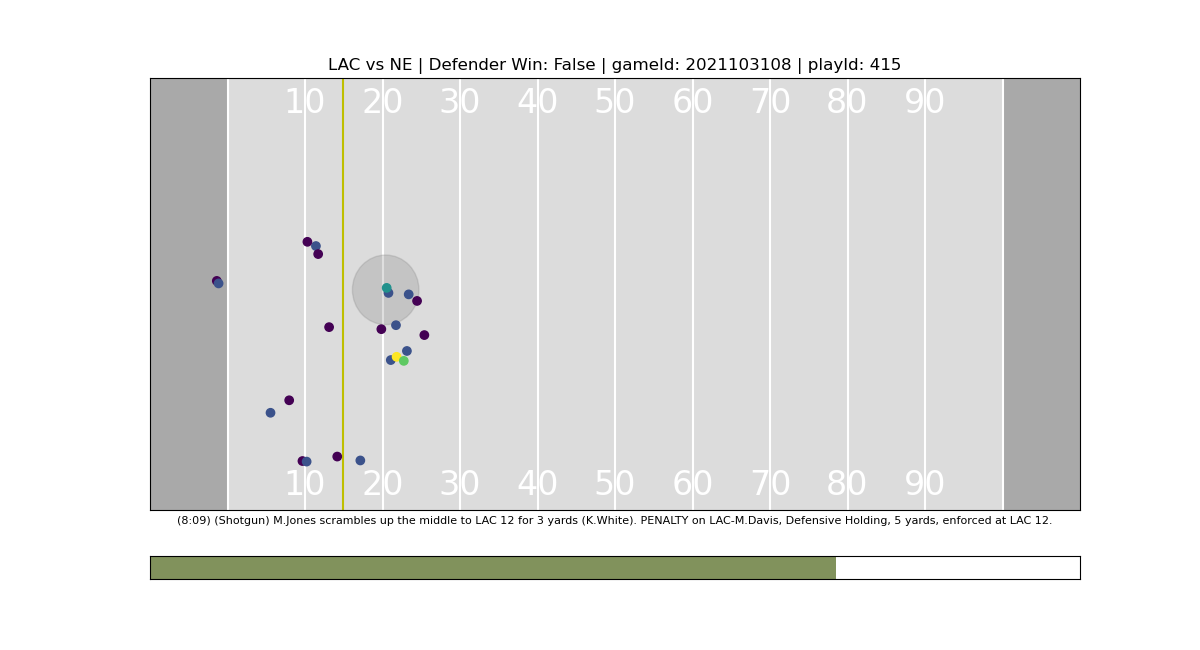

In [109]:
data = fetch_play(matchups_detail_wins)
# data = fetch_play(matchups_detail_wins, gameId=2021100400, playId=4161, matchup_index=0)
# data = fetch_play(matchups_detail_wins, gameId=2021100304, playId=965, matchup_index=2)
# data = fetch_play(matchups_detail_wins, gameId=2021091205, playId=878, matchup_index=1)

tracking_play, qb_play_pressure, info, play_description, scrim_x = data

# Build base plot
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [19, 1]})
fig.set_figheight(6.5)
fig.set_figwidth(12)

ax[1].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
r = Rectangle((0, 0), 1, 1, facecolor = 'indianred')
ax[1].add_patch(r)
g = Rectangle((0, 0), 1, 1, facecolor = 'green')
ax[1].add_patch(g)


ax[0].set_xlim(0, 120)
ax[0].set_ylim(0, 53.3)
ax[0].set_xlabel(play_description, fontsize=8)
ax[0].set_title(info)

# Add yard lines
for i in range(10, 120, 10):
    ax[0].axvline(i, color='w')
    
# Define line of scrimmage
ax[0].axvline(scrim_x, color='y')

# Color field
ax[0].set_facecolor("darkgray")
ax[0].add_patch(Rectangle((10, 0), 100, 53.3, facecolor = 'gainsboro'))
    
# Format yardline labels
ax[0].get_yaxis().set_visible(False)
ax[0].set_xticks(range(20, 110, 10), range(10, 100, 10), fontsize=24, color='w')
ax[0].tick_params(
    axis="x",
    direction="in",
    pad=-30,
    top=False,
    labeltop=True,
    bottom=False,
    labelbottom=True
)

# Initialize scatter plot
scatter = ax[0].scatter([], [],zorder=10)
c = Circle((5, 5), radius=1, alpha=0.25, color='gray',zorder=5)
ax[0].add_patch(c)

# Function to update plot animation
def update(frameId):
    tracking_frame = tracking_play.loc[
        (tracking_play['frameId'] == frameId)
    ]
    scatter.set_offsets(np.c_[tracking_frame['x'], tracking_frame['y']])
    scatter.set_array(tracking_frame['color_code'])
    
    qb_slice = qb_play_pressure.loc[
        (qb_play_pressure['frameId'] == frameId+1)
    ]
    
    pressure = qb_slice['distance'].iloc[0]
    x = qb_slice['x'].iloc[0]
    y = qb_slice['y'].iloc[0]
    
    c.set(radius=pressure)
    c.center=(x, y)
    
    r.set(width=1.167-(pressure/10), alpha =1-(pressure/10))
    g.set(width=1.167-(pressure/10), alpha = (pressure/10))
    
    return scatter, c, r, g

# Animate plot
anim = FuncAnimation(fig, update, frames=tracking_play['frameId'].max(), interval=100, repeat=True)
plt.show()

writergif = animation.PillowWriter(fps=10) 
anim.save('./test.gif', writer=writergif)

### 4. Building Features

In [11]:
players_cleaned = players.copy()
players_cleaned['height'] = players_cleaned['height'].apply(
    lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))
players_cleaned['age'] = players_cleaned['birthDate'].str.extract('(\d{4})')
players_cleaned = players_cleaned[players_cleaned['age'].notna()]
players_cleaned['age'] = players_cleaned['age'].apply(lambda x: 2021 - int(x))
players_cleaned.drop(columns=['birthDate', 'displayName', 'collegeName', 'officialPosition'], inplace=True)
players_cleaned.head()

,nflId,height,weight,age
0,25511,76,225,44
1,28963,77,240,39
2,29550,76,328,39
3,29851,74,225,38
4,30078,74,228,39


In [12]:
# Merge in player features
hwa_features = matchups_detail_wins\
    .merge(players_cleaned.add_suffix('_defender'))\
    .merge(players_cleaned.add_suffix('_offender'))\
    .drop(columns=['gameId', 'playId', 'nflId_defender', 'nflId_offender'])
hwa_features.head()

,matchup_duration,pressure_gain_pct,pressure_gain,matchup_win,height_defender,weight_defender,age_defender,height_offender,weight_offender,age_offender
0,13.0,0.469687,True,True,75,265,29,78,305,26
1,18.0,-0.157633,False,False,75,297,28,78,305,26
2,15.0,0.152200,True,False,75,297,28,78,305,26
3,19.0,0.291779,True,False,75,297,28,78,305,26
4,17.0,-0.102950,False,False,75,297,28,78,305,26


### 5. Training Model

In [13]:
# Define dependent variable
X = hwa_features.drop('matchup_win', axis=1)
y = hwa_features['matchup_win'].apply(lambda x: int(x))

In [14]:
# Use sklearn to split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create scaler instance
X_scaler = StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create the Keras Sequential model
nn = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn.add(tf.keras.layers.Dense(units=4, activation="relu", input_dim=len(X_train.iloc[0])))

# Add hidden layers
nn.add(tf.keras.layers.Dense(units=8, activation="relu"))
nn.add(tf.keras.layers.Dense(units=4, activation="relu"))

# Add the output layer that uses a probability activation function
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 40        
                                                                 
 dense_1 (Dense)             (None, 8)                 40        
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
# Fit the model to the training data
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
273/273 [==============================] - 3s 2ms/step - loss: 0.5387 - accuracy: 0.7287
Epoch 2/100
273/273 [==============================] - 1s 2ms/step - loss: 0.4150 - accuracy: 0.7556
Epoch 3/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3918 - accuracy: 0.7663
Epoch 4/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3851 - accuracy: 0.7781
Epoch 5/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3786 - accuracy: 0.7878
Epoch 6/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3716 - accuracy: 0.7899
Epoch 7/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3654 - accuracy: 0.8001
Epoch 8/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3603 - accuracy: 0.8063
Epoch 9/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3559 - accuracy: 0.8117
Epoch 10/100
273/273 [==============================] - 1s 2ms/step - loss: 0.3520 - accura

In [17]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

91/91 - 0s - loss: 0.3415 - accuracy: 0.8238 - 478ms/epoch - 5ms/step
Loss: 0.3415359556674957, Accuracy: 0.8237718939781189


#### Next steps
1. Show only max-pressure player in play animation
2. Build definition for post-matchup trouble in false negatives
3. Check for matchup transition or false matchups in false positives
4. Gather additional features for model training
5. Create python file to show play plot on dashboard
6. Tweak database to optimize generation